<img src="https://raw.githubusercontent.com/astrolabsoftware/fink-notebook-template/main/Fink_PrimaryLogo_WEB.jpg" width=400 />

# Fink case study: Ephemerides for Solar System Science

This notebook shows how to use the <a href="https://ssp.imcce.fr/webservices/miriade/">Miriade</a> IMCCE service with Fink Solar System Object data.

Authors: Julien Peloton, Benoit Carry, Max Mahlke.

In [1]:
import io
import requests

import pandas as pd
import numpy as np

import astropy.units as u

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')

import time

from astropy.coordinates import SkyCoord
import astropy.units as u

In [2]:
# Disctionary for filters
filters = {1:'g', 2:'r', 3:'i'}

## Fink data

In [3]:
# Get data from FINK 
r = requests.post(
    'https://fink-portal.org/api/v1/sso',
    json={
        'n_or_d': '33803',
        'withEphem': True,
        'output-format': 'json'
    }
)

# Sort by epoch - critical for ephemerides speed up
sso = pd.read_json(io.BytesIO(r.content))
sso = sso.sort_values(by='i:jd').reset_index(drop=True)

## Magnitude comparison

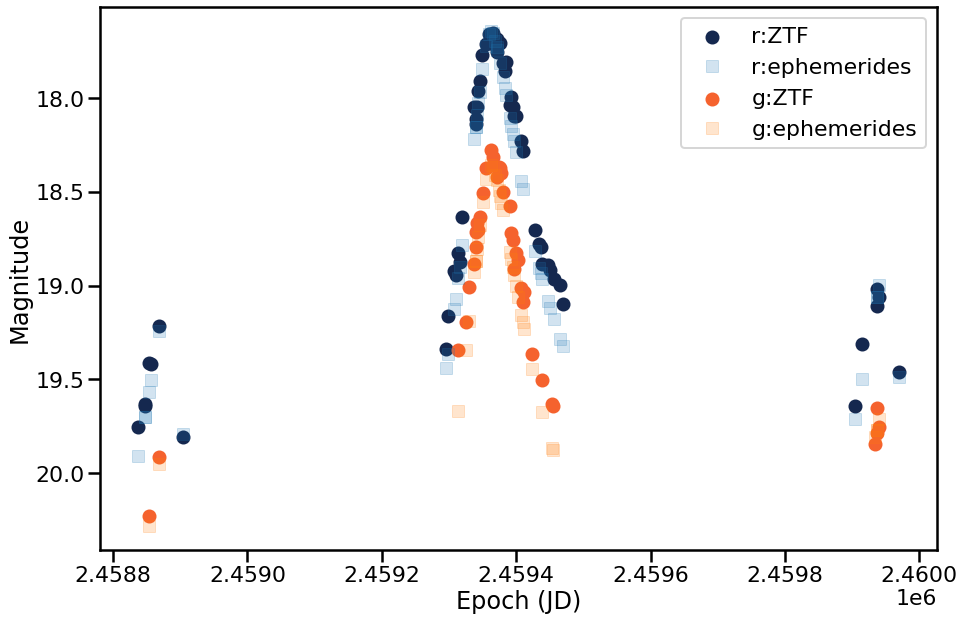

In [4]:
# Simple plot
filts = sso['i:fid'].unique()

fig, ax = plt.subplots(
    1, 1, 
    figsize=(15, 10), 
)

colors = ['#15284F', '#F5622E']
for i,f in enumerate(filts):
    cond = sso['i:fid']==f
    
    ax.scatter(
        sso.loc[cond,'i:jd'], 
        sso.loc[cond,'i:magpsf'], 
        label='{:}:ZTF'.format(filters[f]),
        color=colors[i],
        alpha=1.0
    )

    ax.plot(
        sso.loc[cond, 'Date'], 
        sso.loc[cond, 'SDSS:{}'.format(filters[f].lower())], 
        ls='', 
        marker='s', 
        label='{}:ephemerides'.format(filters[f].lower()), alpha=0.2)

ax.set_ylim(ax.get_ylim()[::-1])
ax.legend(loc='best')
ax.set_ylabel('Magnitude')
ax.set_xlabel('Epoch (JD)');

## Position comparison

(-0.5, 0.5)

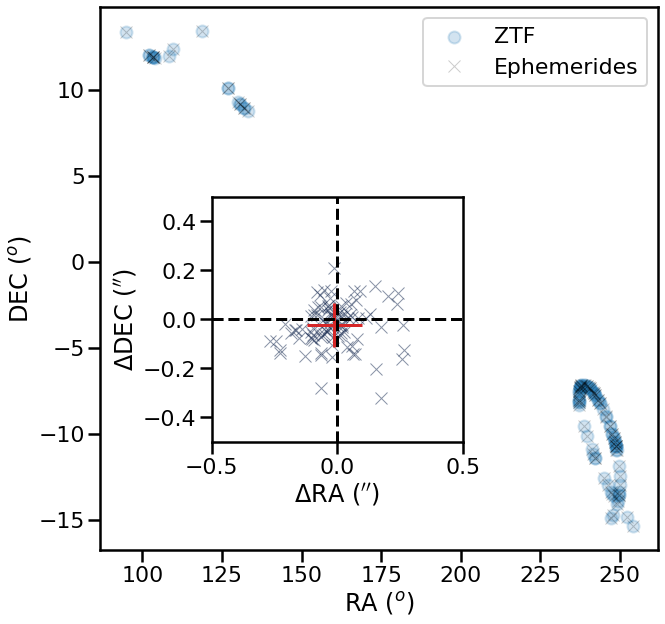

In [6]:
fig, ax = plt.subplots(
    figsize=(10, 10), 
    sharex=True,
)

ax.scatter(
    sso['i:ra'], sso['i:dec'], 
    alpha=0.2, color='C0',
    label='ZTF'
)
    
ax.plot(
    sso.RA, sso.Dec, 
    ls='', color='black', marker='x', alpha=0.2, 
    label='Ephemerides'
)
ax.legend(loc='best')
ax.set_xlabel('RA ($^o$)')
ax.set_ylabel('DEC ($^o$)')

axins = ax.inset_axes([0.2, 0.2, 0.45, 0.45])

deltaRAcosDEC = (sso['i:ra'] - sso.RA) * np.cos(np.radians(sso['i:dec'])) * 3600
deltaDEC = (sso['i:dec']- sso.Dec) * 3600
axins.plot(
    deltaRAcosDEC, deltaDEC, 
    ls='', color=colors[0], marker='x', alpha=0.5
)
axins.errorbar(
    np.mean(deltaRAcosDEC), np.mean(deltaDEC), 
    xerr=np.std(deltaRAcosDEC), yerr=np.std(deltaDEC), 
    color='C3'
)
axins.axhline(0, ls='--', color='black')
axins.axvline(0, ls='--', color='black')
axins.set_xlabel(r'$\Delta$RA ($^{\prime\prime}$)')
axins.set_ylabel(r'$\Delta$DEC ($^{\prime\prime}$)')
axins.set_xlim(-0.5, 0.5)
axins.set_ylim(-0.5, 0.5)

## Solar System Object Fink Table (SSOFT) 

On top of individual lightcurves, we also provide a table containing aggregated parameters for Solar System objects in Fink. This table is updated once a month, with all data in Fink. The list of arguments for retrieving alert data can be found at https://fink-portal.org/api/v1/ssoft, and the schema of the table (json) can be found at https://fink-portal.org/api/v1/ssoft?schema

In [8]:
import io
import requests
import pandas as pd

r = requests.post(
  'https://fink-portal.org/api/v1/ssoft',
  json={
    'output-format': 'parquet',
    'sso_number': 33803
  }
)

# Format output in a DataFrame
pdf = pd.read_parquet(io.BytesIO(r.content))

In [9]:
pdf

,ssnamenr,mean_astrometry,max_phase_1,max_phase_2,max_cos_lambda,fit,R,min_cos_lambda,median_error_phot_1,median_error_phot_2,...,H_1,err_R,mean_cos_lambda,alpha0,status,sso_name,sso_number,obliquity,version,flag
36048,33803,0.120459,33.985825,34.230663,0.152339,0.0,0.606226,0.018581,0.105845,0.094449,...,16.64271,0.222096,0.081382,137.00177,2.0,1999 VK210,33803.0,NaN,2023.11,0


In [11]:
!curl https://fink-portal.org/api/v1/ssoft?schema

{
  "args": {
    "ssnamenr": {
      "type": "str", 
      "description": "Designation (name or number) of the object from MPC archive as given by ZTF"
    }, 
    "sso_name": {
      "type": "str", 
      "description": "Official name or provisional designation of the SSO"
    }, 
    "sso_number": {
      "type": "int", 
      "description": "IAU number of the SSO"
    }, 
    "last_jd": {
      "type": "double", 
      "description": "Julian Date for the last detection in Fink, in UTC"
    }, 
    "H_1": {
      "type": "double", 
      "description": "Absolute magnitude for the ZTF filter band g"
    }, 
    "H_2": {
      "type": "double", 
      "description": "Absolute magnitude for the ZTF filter band r"
    }, 
    "err_H_1": {
      "type": "double", 
      "description": "Uncertainty on the absolute magnitude for the ZTF filter band g"
    }, 
    "err_H_2": {
      "type": "double", 
      "description": "Uncertainty on the absolute magnitude for the ZTF filter band r"
   